# eda003
距離分布による足切り効果確認

In [47]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [48]:
exp_name = 'eda003'
memo = 'exp001のhypopt'

In [49]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import itertools
from tqdm import tqdm
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import multiprocessing
import Levenshtein
import difflib
import pickle
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [50]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'

In [51]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    #print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [52]:
def add_orgin_data(df, org_df):
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [53]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5

In [54]:
train_origin = pd.read_csv(INPUT_DIR + "train.csv")
# trainデータの分割
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
    train_origin.loc[val_idx, "set"] = i

methods = []
Ns = []
Ls = []
scores = []

In [55]:
categories_dist = pd.read_csv(OUTPUT_DIR + 'prep/distance_dist/distance_dist.csv')
categories_dist = categories_dist[categories_dist['count'] > 100].copy()
categories_dist['1sigma'] = categories_dist['mean'] + (categories_dist['std']*1)
categories_dist['2sigma'] = categories_dist['mean'] + (categories_dist['std']*2)
categories_dist['3sigma'] = categories_dist['mean'] + (categories_dist['std']*3)

# 足切りなし

In [56]:
def extract_candidate(df, dist_th=None):
    dfs = []
    candidates = pd.DataFrame()
    for country, country_df in df.groupby("country"):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        country_df = country_df.explode(['match_id','d_near'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()

        if dist_th is not None:
            country_df = country_df[country_df['d_near'] < country_df['categories'].map(cat_dist_th).fillna(5)].copy()

        dfs.append(country_df)

    df = pd.concat(dfs).reset_index(drop=True)
    return df

# 足切りなし

In [57]:
method = 'w/o cutoff'
for N_NEIGHBORS in [10,20,30,40]:
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0]), 
        extract_candidate(train_origin[train_origin["set"]==1]), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10248563 0.8903988462445916
20 21627709 0.9130873957122682
30 33003055 0.9242732307077846
40 44374562 0.9313886243621975


# カテゴリごとの距離で足切り

In [58]:
method = 'percentile75'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 9414953 0.8869668268663572
20 18997782 0.9081040675026321
30 28083545 0.9183153938021523
40 36819211 0.9246967146459395


In [59]:
method = 'percentile90'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10066245 0.8900145306882149
20 20952062 0.9124676953388525
30 31610505 0.9234769777856286
40 42085539 0.9304394238508866


In [60]:
method = 'percentile95'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10180465 0.8903069341160568
20 21363236 0.9129412872418928
30 32438039 0.9240868985991305
40 43414748 0.9311576317154469


In [61]:
method = '1sigma'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10206084 0.8903565799764688
20 21457269 0.9130155612458412
30 32628705 0.9241777811606814
40 43726236 0.9312699404938806


In [62]:
method = '2sigma'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10230277 0.8903853233804138
20 21551954 0.9130621281527412
30 32833557 0.9242388222154948
40 44075250 0.9313441615325808


In [63]:
method = '3sigma'
for N_NEIGHBORS in [10,20,30,40]:
    cat_dist_th = {c:d for c,d in zip(categories_dist['categories'], categories_dist[method])}
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0], cat_dist_th), 
        extract_candidate(train_origin[train_origin["set"]==1], cat_dist_th), 
    ])
    train = add_orgin_data(train, train_origin)
    L = len(train)
    score = calc_max_score(train, train_origin)

    methods.append(method)
    Ns.append(N_NEIGHBORS)
    Ls.append(L)
    scores.append(score)

    print(N_NEIGHBORS, L, score)

10 10238579 0.8903905042179885
20 21585218 0.913072284936009
30 32906269 0.9242547538506152
40 44201380 0.9313659764917266


In [64]:
result = pd.DataFrame({
    'method':methods,
    'n_neighbors':Ns,
    'record_cnt':Ls,
    'max_score':scores
})
result.head()

,method,n_neighbors,record_cnt,max_score
0,w/o cutoff,10,10248563,0.890399
1,w/o cutoff,20,21627709,0.913087
2,w/o cutoff,30,33003055,0.924273
3,w/o cutoff,40,44374562,0.931389
4,percentile75,10,9414953,0.886967


/tmp/ipykernel_24552/2701367336.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(tmp['record_cnt'], tmp['max_score'], "-or", label=m, color=cp[i])
/tmp/ipykernel_24552/2701367336.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(tmp['record_cnt'], tmp['max_score'], "-or", label=m, color=cp[i])
/tmp/ipykernel_24552/2701367336.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(tmp['record_cnt'], tmp['max_score'], "-or", label=m, color=cp[i])
/tmp/ipykernel_24552/2701367336.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-or" (-> color='r'). The keyword argument will take 

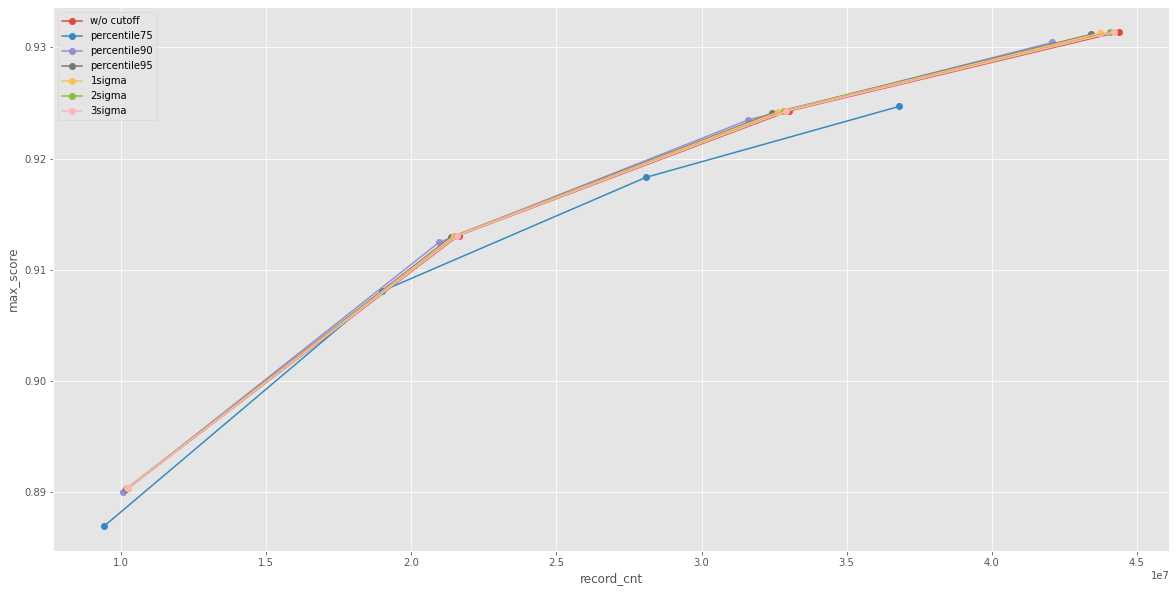

In [71]:
cp = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(20,10))

for i, m in enumerate(result['method'].unique()):
    tmp = result[result['method'] == m].copy()
    ax.plot(tmp['record_cnt'], tmp['max_score'], "-or", label=m, color=cp[i])
    ax.legend()
    ax.set_xlabel('record_cnt')
    ax.set_ylabel('max_score')

['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']